# Jupyter pour le développement du modèle 

In [89]:
using Test, LinearAlgebra, PlutoUI, Plots, NCDatasets , JuMP , CPLEX, AmplNLWriter, Statistics, NCDatasets

In [29]:
using JuMP
using NCDatasets


function extract_data_from_netcdf(file_path)
    myds = NCDataset(file_path, "r")
    
    blk0 = myds.group["Block_0"]

    nbUnit = blk0.dim["NumberUnits"]

    T = blk0.dim["TimeHorizon"]
    m = blk0.dim["NumberUnits"]
    Δt = blk0.dim["NumberIntervals"]

    ThUnits = []
    min_power = []
    max_power = []
    delta_ramp_up = []
    delta_ramp_down = []
    start_up_cost = []
    linear_term = []
    quad_term = []
    InitUpDownTime = []
    MinDownTime = []
    MinUpTime = []
    InitialPower = []

    const_term = []

    for ky in keys(blk0.group)
        if haskey(blk0.group[ky].attrib, "type") &&
            blk0.group[ky].attrib["type"] == "ThermalUnitBlock"

            push!(ThUnits, ky)
            push!(min_power, blk0.group[ky]["MinPower"][:])
            push!(max_power, blk0.group[ky]["MaxPower"][:])
            push!(delta_ramp_up, blk0.group[ky]["DeltaRampUp"][:])
            push!(delta_ramp_down, blk0.group[ky]["DeltaRampDown"][:])
            push!(start_up_cost, blk0.group[ky]["StartUpCost"][:])
            push!(linear_term, blk0.group[ky]["LinearTerm"][:])
            push!(const_term, blk0.group[ky]["ConstTerm"][:])
            push!(quad_term, blk0.group[ky]["QuadTerm"][:])
            push!(InitUpDownTime, blk0.group[ky]["InitUpDownTime"][:])
            push!(MinDownTime, blk0.group[ky]["MinDownTime"][:])
            push!(MinUpTime, blk0.group[ky]["MinUpTime"][:])
            push!(InitialPower, blk0.group[ky]["InitialPower"][:])

        end
    end

    min_power = vcat(min_power...)
    max_power = vcat(max_power...)
    delta_ramp_up = vcat(delta_ramp_up...)
    delta_ramp_down = vcat(delta_ramp_down...)
    start_up_cost = vcat(start_up_cost...)
    linear_term = vcat(linear_term...)
    const_term = vcat(const_term...)
    quad_term = vcat(quad_term...)
    InitUpDownTime = vcat(InitUpDownTime...)
    MinDownTime = vcat(MinDownTime...)
    MinUpTime = vcat(MinUpTime...)
    InitialPower = vcat(InitialPower...)

    MinDownTime = float(MinDownTime)
    MinUpTime = float(MinUpTime)

    d = blk0["ActivePowerDemand"][:]

    close(myds)

    return T, m, Δt, ThUnits, min_power, max_power, delta_ramp_up, delta_ramp_down, start_up_cost, linear_term, const_term, quad_term, d, InitUpDownTime, MinDownTime, MinUpTime, InitialPower
end


function extract_data_from_netcdf_hydro(file_path)
    myds = NCDataset(file_path, "r")
    blk0 = myds.group["Block_0"]
    active_power_demand_hydro = blk0["ActivePowerDemand"][:]
    blk = blk0.group["UnitBlock_0"]

    StartArc = blk["StartArc"][:]
    EndArc = blk["EndArc"][:]
    Inflows = blk["Inflows"][:]
    InitialVolume = blk["InitialVolumetric"][:]
    MaxVolume = blk["MaxVolumetric"][:]
    InitialFlowRate = blk["InitialFlowRate"][:]
    DeltaRampUp_hydro = blk["DeltaRampUp"][:]
    DeltaRampDown_hydro = blk["DeltaRampDown"][:]
    MinFlow = blk["MinFlow"][:]
    MaxFlow = blk["MaxFlow"][:]
    MinPower = blk["MinPower"][:]
    MaxPower = blk["MaxPower"][:]
    LinearTerm_hydro = blk["LinearTerm"][:]
    ConstantTerm_hydro = blk["ConstantTerm"][:]

    close(myds)
    return StartArc, EndArc, Inflows, InitialVolume, MaxVolume, InitialFlowRate, DeltaRampUp_hydro, DeltaRampDown_hydro, MinFlow, MaxFlow, MinPower, MaxPower,LinearTerm_hydro,ConstantTerm_hydro
   
end








extract_data_from_netcdf_hydro (generic function with 1 method)

In [116]:
function solve_unit_commitment_hydro(InitialPower,T, m, Δt, ThUnits, min_power, max_power, delta_ramp_up, delta_ramp_down, start_up_cost, linear_term, const_term, quad_term, d, InitUpDownTime,MinDownTime, MinUpTime, StartArc, EndArc, Inflows, InitialVolume, MaxVolume, InitialFlowRate, DeltaRampUp_hydro, DeltaRampDown_hydro, MinFlow, MaxFlow, MinPower, MaxPower,LinearTerm_hydro,ConstantTerm_hydro)
    model = Model(CPLEX.Optimizer)

    
    K = size(InitialVolume)[1]   #nombre de réservoirs 
    J = size(InitialFlowRate)[1]  #nombre d'arcs (turbines ou pompes) reliant les réservoirs

    ## function pour créer une matrice de taille J*K, vaut -1 si la turbine j part du réservoir k et 1 si la turbine j arrive au réservoir

    matrice_co = zeros(Float64, J, K)

    for k in 1:K
        for j in 1:J
            if StartArc[j] == k
                matrice_co[j,k] = -1
            end
        end
        for j in 1:J
            if EndArc[j] == k
                matrice_co[j,k] = 1
            end
        end
    end
    
    #exemple:
    # StartArc = [1,2,2,3,4]
    # EndArc = [2,4,4,2,1]
    # matrice_co = [-1.0 1.0 0.0 0.0; 0.0 -1.0 0.0 1.0; 0.0 -1.0 0.0 1.0; 0.0 1.0 -1.0 0.0; 1.0 0.0 0.0 -1.0]

    
    ## Variables pour l'hydraulique

    @variable(model, v[1:K, 1:T] >= 0) #variable volume du réservoir k (k de 1 à K)
    @variable(model, f[1:J, 1:T] >= 0) #variable flowrate sur l'arc (turbine ou pompe) j (j de 1 à J)
    @variable(model, x_hydro[1:J, 1:T] >= 0, Bin) #variable binaire, on allume ou on éteint la turbine/pompe j 
    @variable(model, p_hydro[1:J, 1:T] >= 0 )  ## puissance hydraulique


    @variable(model, x[1:m, 1:T] >= 0, Bin)  # variable binaire, vaut 1 quand l'unité est allumée et 0 lorsqu'elle est éteinte
    @variable(model, p[1:m, 1:T]>=0) #variable puissance générée par unité de production
    @variable(model, cost[1:m, 1:T] >= 0) #variable coût par unité de production

    @variable(model, z1[1:m, 1:T],Bin) ##vaut 1 si pas de changement d'état et 0 sinon


    # Contraintes pour définir la variable z1


    @constraint(model,c1[i=1:m,t=2:T], z1[i, t] >= (x[i,t]-x[i,t-1])) #row 'c8167':  0 >= 1.
    @constraint(model,c3[i=1:m,t=2:T], z1[i, t] <= x[i,t])
    @constraint(model,c4[i=1:m,t=2:T], z1[i, t] <= x[i,t-1])


    ######################### Contraintes  Combustion ####################"""
    
    # Contraintes pour définir la durée minimale au cours de laquelle l'unité doit être éteinte/allumée
    for i in 1:m
        for t in 1:(T-max(Int(MinUpTime[i]),Int(MinDownTime[i])))
            @constraint(model, sum(x[i,h] for h in t+1:t+Int(MinUpTime[i])) >= Int(MinUpTime[i])*(x[i,t+1]-x[i,t]))

                    
            @constraint(model, sum(1-x[i,h] for h in t+1:t+Int(MinDownTime[i])) >= Int(MinDownTime[i])*(x[i,t]-x[i,t+1]))
        end
        for t in (T-max(Int(MinUpTime[i]),Int(MinDownTime[i]))):T-1
            @constraint(model,x[i,t+1]==x[i,t])
        end
    end

    # Contraintes pour définir la puissance
    @constraint(model,cint4[i=1:m], p[i, 1] >= InitialPower[i],base_name="test5") #puissance à l'instant initial
    @constraint(model,c11[i=1:m,t=2:T], min_power[i]*x[i,t] <= p[i, t],base_name="test6")#contrainte servant à la fois à borner p et à définir la variable x
    @constraint(model,c12[i=1:m,t=2:T], p[i, t] <= max_power[i]*x[i,t],base_name="test7")
    @constraint(model,c13[i=1:m,t=2:T-1], p[i, t+1]-p[i,t] <= delta_ramp_up[i]+(min_power[i]-delta_ramp_up[i])*(1-x[i,t]))#définition du gradient limitant l'augmentation de p entre deux pas de temps
    @constraint(model,c14[i=1:m,t=2:T-1], -p[i, t+1]+p[i,t] <= delta_ramp_down[i]+(min_power[i]-delta_ramp_down[i])*(1-x[i,t]))#définition du gradient limitant la diminution de p entre deux pas de temps

    # contrainte sur le calcul du coût 
    ##si z1 égale à 1 on fait payer le coût de démarrage 
    @constraint(model,c15[i=1:m,t=2:T], cost[i, t] == z1[i,t] * (start_up_cost[i]) +
                               linear_term[i] * p[i, t] +
                               const_term[i] * x[i,t],base_name="test10")


    # Fonction objectif
    @objective(model, Min, sum(cost[i, t] for i in 1:m, t in 1:T))

    #### CONTRAINTES SPÉCIFIQUES AUX UNITÉS HYDRAULIQUES

    
    
    

    # Contraintes sur le volume des réservoirs

    for k in 1:K
        @constraint(model, v[k, 1] == InitialVolume[k]) # volume initial
        for t in 2:T
            @constraint(model, 0<= v[k, t])
            @constraint(model, v[k, t]<= MaxVolume[k])
            @constraint(model, v[k, t] == v[k,t-1] + Inflows[k] + sum(f[j,t]*matrice_co[j,k] for j in 1:J))
        end
    end


    # Contraintes sur le flowrate de chaque arc

    for j in 1:J
        @constraint(model, f[j, 1] == InitialFlowRate[j]) # flowrate initial (vaut 0)
        for t in 1:T-1
            @constraint(model, MinFlow[j] <= f[j, t])
            @constraint(model, f[j, t] <= MaxFlow[j])
            @constraint(model, f[j,t+1] - f[j,t] <= DeltaRampUp_hydro[j]) ## Ajouter une contrainte cohérente pour l'instant T
            @constraint(model, -f[j,t+1] + f[j,t] <= DeltaRampDown_hydro[j])

        end
    end


    # Contraintes sur la production hydroélectrique (linear term (positif pour une turbine, négatif pour une pompe)* flowrate)

    for j in 1:J
        for t in 1:T
            @constraint(model, MinPower[j]*x_hydro[j] <= p_hydro[j, t])
            @constraint(model, p_hydro[j, t] <= MaxPower[j]*x_hydro[j])
            @constraint(model, p_hydro[j,t] == MinPower[j]*0 + LinearTerm_hydro[j]*f[j,t])
        end
    end


    # Contrainte de puissance avec unités thermiques + unité hydraulique qui doit répondre à la demande
    for t in 1:T
        @constraint(model, sum(p[i, t] for i in 1:m) + sum(p_hydro[j,t] for j in 1:J) >= d[t])
    end

    # Calcul de l'optimisation
    optimize!(model)

    # Solutions
    return value.(x), value.(p), value.(cost), value.(x_hydro), value.(p_hydro), value.(f), value.(v)

end

T, m, Δt, ThUnits, min_power, max_power, delta_ramp_up, delta_ramp_down, start_up_cost, linear_term, const_term, quad_term, d, InitUpDownTime, MinDownTime, MinUpTime, InitialPower = extract_data_from_netcdf("T-ramp/10_0_3_w.nc4")
StartArc, EndArc, Inflows, InitialVolume, MaxVolume, InitialFlowRate, DeltaRampUp_hydro, DeltaRampDown_hydro, MinFlow, MaxFlow, MinPower, MaxPower,LinearTerm_hydro,ConstantTerm_hydro =extract_data_from_netcdf_hydro("T-ramp/Aurland_1000.nc4")
solution_x, solution_p, solution_cost, solution_xhydro, solution_phydro, f,v = solve_unit_commitment_hydro(InitialPower,T, m, Δt, ThUnits, min_power, max_power, delta_ramp_up, delta_ramp_down, start_up_cost, linear_term, const_term, quad_term, d, InitUpDownTime,MinDownTime,MinUpTime,StartArc, EndArc, Inflows, InitialVolume, MaxVolume, InitialFlowRate, DeltaRampUp_hydro, DeltaRampDown_hydro, MinFlow, MaxFlow, MinPower, MaxPower,LinearTerm_hydro,ConstantTerm_hydro)




Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 3 times.
MIP Presolve eliminated 3302 rows and 1379 columns.
MIP Presolve modified 1327 coefficients.
Aggregator did 147 substitutions.
Reduced MIP has 1215 rows, 442 columns, and 3396 nonzeros.
Reduced MIP has 160 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (9.58 ticks)
Found incumbent of value 1147608.538982 after 0.05 sec. (11.43 ticks)
Probing changed sense of 83 constraints.
Probing time = 0.00 sec. (3.43 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 156 rows and 83 columns.
MIP Presolve modified 204 coefficients.
Reduced MIP has 1059 rows, 359 columns, and 2913 nonzeros.
Reduced MIP has 77 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.45 ticks)
Probing time = 0.00 sec. (1.40 ticks)
Cover probing fixed 0 vars, tightened 22 bounds.
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve modified 50 coefficients.
Reduced MIP has 1059 row

([1.0 1.0 … 1.0 1.0; 0.0 -0.0 … 0.0 0.0; … ; 0.0 -0.0 … 0.0 0.0; 0.0 -0.0 … 0.0 0.0], [110.0 44.0 … 85.432603 44.0; 82.528018 0.0 … 0.0 0.0; … ; 196.412544 0.0 … 0.0 0.0; 258.264551 0.0 … 0.0 0.0], [0.0 3144.317659 … 4971.00986119284 3144.317659; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1.0 0.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0; … ; 1.0 0.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0], [0.0 8.997660000000002 … 8.997660000000002 9.0; 0.0 -5.195843755245733e-14 … 0.0 0.0; … ; 0.0 279.99000000000007 … 279.99000000000007 280.0; 0.0 279.99000000000007 … 279.99000000000007 280.0], [0.0 0.009324 … 0.009324 0.00932642487046632; 0.0 -4.440892098500626e-16 … 0.0 0.0; … ; 0.0 0.13500000000000004 … 0.13500000000000004 0.13500482160077146; 0.0 0.13500000000000004 … 0.13500000000000004 0.13500482160077146], [1.5 1.5006246050547054 … 0.0 0.0006246050547032756; 224.0 223.77918327717097 … 220.65577340896485 220.42290205927014; … ; 97.0 97.40685379577134 … 104.6424034973181 105.04927175789174; 1.4 1.4

In [14]:
ThUnits

150-element Vector{Any}:
 "UnitBlock_0"
 "UnitBlock_1"
 "UnitBlock_2"
 "UnitBlock_3"
 "UnitBlock_4"
 "UnitBlock_5"
 "UnitBlock_6"
 "UnitBlock_7"
 "UnitBlock_8"
 "UnitBlock_9"
 "UnitBlock_10"
 "UnitBlock_11"
 "UnitBlock_12"
 ⋮
 "UnitBlock_138"
 "UnitBlock_139"
 "UnitBlock_140"
 "UnitBlock_141"
 "UnitBlock_142"
 "UnitBlock_143"
 "UnitBlock_144"
 "UnitBlock_145"
 "UnitBlock_146"
 "UnitBlock_147"
 "UnitBlock_148"
 "UnitBlock_149"

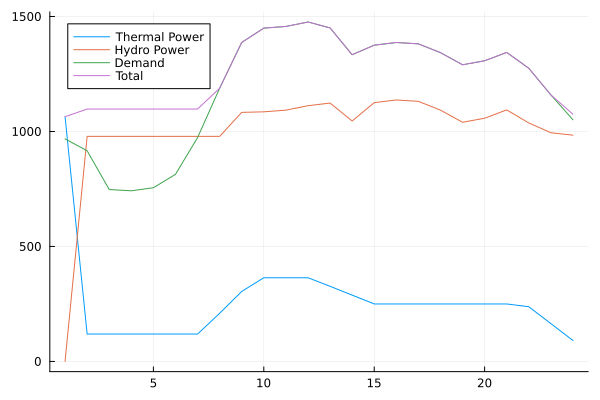

In [113]:

thermal_power = sum(solution_p[i,:] for i in 1:length(ThUnits))
hydro_power = sum(solution_phydro[i,:] for i in 1:12)
total = hydro_power+thermal_power

plot([thermal_power hydro_power d total],label = ["Thermal Power" "Hydro Power" "Demand" "Total"])
# plot([total])


In [1]:
hydro_power = sum(solution_phydro[i,:] for i in 12)
Max = sum(MaxPower)
Max_24 = fill(1,24)*Max
plot([hydro_power Max_24],label = ["Hydro total" "total max"])
title!("Production journalière du réseau de barage")
xlabel!("h")
ylabel!("W")

LoadError: UndefVarError: `solution_phydro` not defined

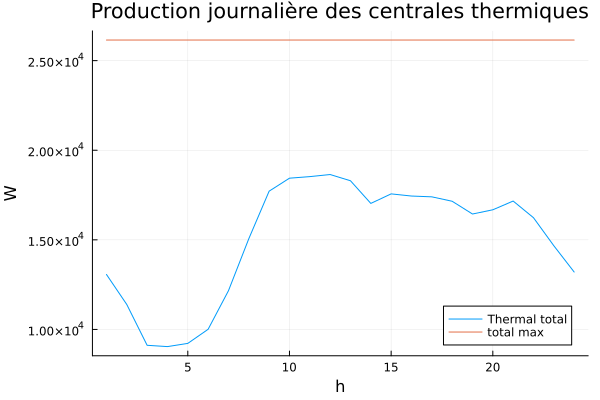

In [8]:
thermal_power = sum(solution_p[i,:] for i in 1:150)
Max_p = sum(max_power)
Max_p_24 = fill(1,24)*Max_p
plot([thermal_power Max_p_24],label = ["Thermal total" "total max"])
title!("Production journalière des centrales thermiques")
xlabel!("h")
ylabel!("W")

In [44]:
start_up_cost
linear_term

LoadError: UndefVarError: `LinearCost` not defined

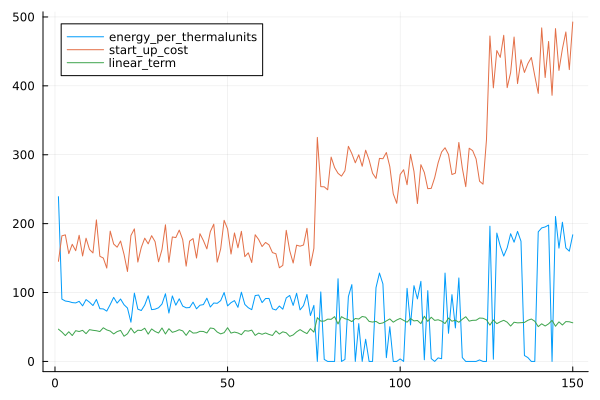

In [53]:
# energy_per_thermalunits = float(fill(1,length(ThUnits)))
for i in 1:length(ThUnits)
    energy_per_thermalunits = 250*sum(solution_p[:,t] for t in 1:T)/(max_power[i]*T)
end

plot([energy_per_thermalunits,start_up_cost,linear_term], label = ["energy_per_thermalunits" "start_up_cost" "linear_term"])

In [99]:
L =[min_power, max_power, delta_ramp_up, delta_ramp_down, start_up_cost, linear_term, const_term, quad_term]
correlation = float(fill(1,length(L)))
for i in 1:length(L)
    correlation[i]=cor(energy_per_thermalunits,L[i])
end
Names =["min_power", "max_power", "ramp_up", "ramp_down", "start_up_cost" ,"linear_term" ,"const_term" ,"quad_term"]

8-element Vector{String}:
 "min_power"
 "max_power"
 "ramp_up"
 "ramp_down"
 "start_up_cost"
 "linear_term"
 "const_term"
 "quad_term"

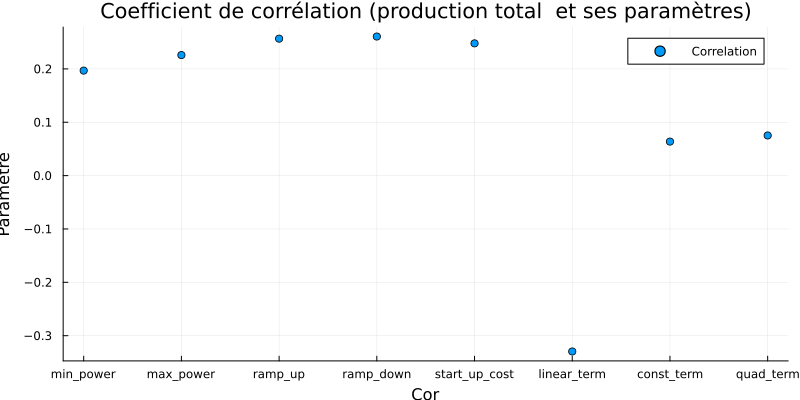

In [88]:
plot(Names,correlation,seriestype=:scatter,label ="Correlation",size=(800,400))
title!("Coefficient de corrélation (production total  et ses paramètres)")
xlabel!("Cor")
ylabel!("Paramètre")    

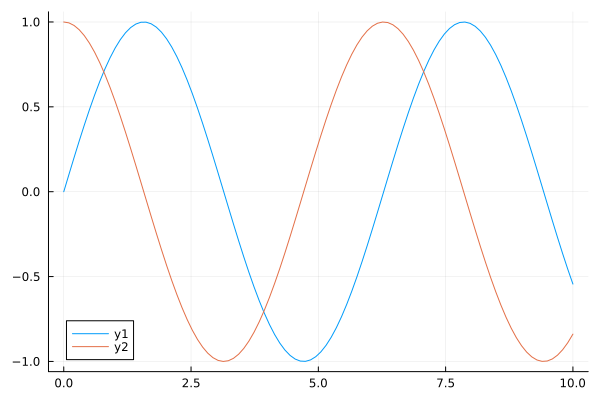

In [33]:
x = range(0, 10, length=100)
y1 = sin.(x)
y2 = cos.(x)
plot(x, [y1 y2])